---
---



# **CIFAR-10 Klassifikation mit ResNet50**

---


*Hinweis zur Codeausführung: Dieses Projekt besteht aus mehreren Modell-Varianten. Nur jeweils ein Block gleichzeitig ausführen*:

---

# **BLOCK 1 - ResNet50 (Frozen)**
*→ Base-Model eingefroren, nur Top-Layers werden trainiert.*

---
# **BLOCK 2 - ResNet50 (Feintuned)**
→ *Komplettes Modell trainierbar (Fine-Tuning aktiviert)*


---
---

In [ ]:
#Bibliotheken importieren

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#TensorFlow-Version anzeigen
print("TensorFlow-Version:", tf.__version__)


TensorFlow-Version: 2.18.0


**Laden und erste Sichtung der CIFAR-10-Daten**

In [ ]:
#CIFAR-10 Datensatz laden
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Datensatzform prüfen
print("Trainingsdaten Shape:", train_images.shape)
print("Testdaten Shape:", test_images.shape)

# Datentyp der Bilder prüfen
print("Datentyp train_images:", train_images.dtype)
print("Datentyp test_images:", test_images.dtype)


Trainingsdaten Shape: (50000, 32, 32, 3)
Testdaten Shape: (10000, 32, 32, 3)
Datentyp train_images: uint8
Datentyp test_images: uint8


In [ ]:
#Trainingsdaten begrenzen auf 10.000 Bilder

n = 10000
train_images = train_images[:n]
train_labels = train_labels[:n]


**Explorative Datenanalyse (EDA)**



In [ ]:
train_images.shape

(10000, 32, 32, 3)

In [ ]:
#check out labels
train_labels

array([[6],
       [9],
       [9],
       ...,
       [1],
       [1],
       [5]], dtype=uint8)

In [ ]:
train_labels.shape

(10000, 1)

In [ ]:
#Labels flatten, um sie besser analysieren zu können
train_labels = train_labels.flatten()
train_labels

array([6, 9, 9, ..., 1, 1, 5], dtype=uint8)

In [ ]:
#Labelverteilung ermitteln
label_counts = pd.Series(train_labels).value_counts().sort_index()
label_counts

,count
0,1005
1,974
2,1032
3,1016
4,999
5,937
6,1030
7,1001
8,1025
9,981


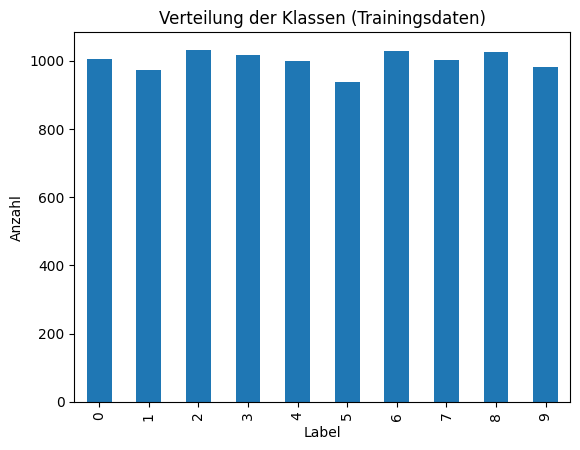

In [ ]:
#Verteilung als Balkendiagramm anzeigen
label_counts.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Anzahl")
plt.title("Verteilung der Klassen (Trainingsdaten)")
plt.show()

**Klassenliste erstellen**

In [ ]:
#Klassenliste gemäß CIFAR-10-Definition
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
#Zuordnung überprüfen
for i in range(10):
    print(f"{i} → {classes[i]}")

0 → airplane
1 → automobile
2 → bird
3 → cat
4 → deer
5 → dog
6 → frog
7 → horse
8 → ship
9 → truck


Normalisierung der Bilddaten


In [ ]:
#Wertebereich von [0, 255] auf [0.0, 1.0] skalieren
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0


#Überprüfen, ob Normalisierung erfolgreich war
print("Min/Max train_images:", train_images.min(), train_images.max())

Min/Max train_images: 0.0 1.0


**One-Hot-Encoding der Labels**

In [ ]:
#Check
print(train_labels.shape)
print(train_labels[0])

(10000,)
6


In [ ]:
#Labels in One-Hot-Vektoren umwandeln
train_labels_cat = to_categorical(train_labels, 10)
test_labels_cat = to_categorical(test_labels, 10)

# Form und Beispiel anzeigen
print("train_labels_cat shape:", train_labels_cat.shape)
print("Beispiel:", train_labels_cat[0])


train_labels_cat shape: (10000, 10)
Beispiel: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


**Funktion zum Anzeigen von Bildern einer bestimmten Klasse (Klassenname und Anzahl anpassbar)**


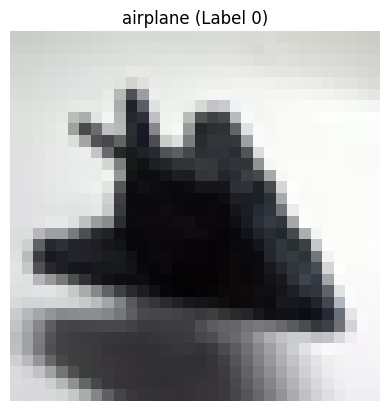

In [ ]:
def show_images_by_class(class_name, n=1):
    target_index = classes.index(class_name)
    shown = 0
    for i in range(len(train_labels_cat)):
        if np.argmax(train_labels_cat[i]) == target_index:
            plt.imshow(train_images[i])
            plt.title(f"{class_name} (Label {target_index})")
            plt.axis("off")
            plt.show()
            shown += 1
            if shown >= n:
                break

#Klassenname und Anzahl anpassbar
show_images_by_class("airplane", n=1)




---



---



---



### **BLOCK 1: ResNet50 (Base frozen) - Standardlauf**

In [ ]:
#Nur das Basis-Modell laden, ohne Klassifikationskopf
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

#Base-Model einfrieren – schützt vor Overfitting und spart Rechenressourcen
base_model.trainable = False

#Kontrollausgabe
print("Base-Model geladen und eingefroren.")

Base-Model geladen und eingefroren.


**ResNet50 (FROZEN) - Nur Klassifikationskopf trainieren (Functional API)**

In [ ]:
#Eingabeschicht für CIFAR-10 (32x32 RGB-Bild)
inputs = Input(shape=(32, 32, 3))

#Hochskalieren auf 224x224 (ResNet50 erwartet das)
x = layers.Resizing(224, 224)(inputs)

#Merkmalsextraktion durch das eingefrorene ResNet50
x = base_model(x, training=False)  # Wichtig: nicht trainieren!

#Klassifikationskopf
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

#Modell zusammensetzen
model = Model(inputs, outputs)

#Modellübersicht anzeigen
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_4 (Resizing)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 23,805,770 (90.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

**Modellkompilierung: Definition von Optimizer, Loss-Funktion und Metrik
Oder kürzer: Kompilierung des Modells**

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Modell erfolgreich kompiliert.")
model.summary()


Modell erfolgreich kompiliert.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_4 (Resizing)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 23,805,770 (90.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

**Training des Klassifikationskopfes (Eingefrorenes Base-Model)**

In [ ]:
#Wir trainieren nur die Dense-Schichten (Top)
#Ziel: Erste Einschätzung der Lernkurve auf 10.000 CIFAR-10-Bildern

history = model.fit(
    train_images,                #Eingabebilder
    train_labels_cat,            #One-Hot-Labels
    epochs=2,                    #Testweise 2 Epochen
    batch_size=32,               #Typischer Batch-Size-Wert
    validation_split=0.2,        #20 % der Trainingsdaten für Validierung
    verbose=1                    #Fortschrittsanzeige
)


Epoch 1/2
250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 339ms/step - accuracy: 0.4014 - loss: 1.7166 - val_accuracy: 0.3015 - val_loss: 3.5639
Epoch 2/2
250/250 ━━━━━━━━━━━━━━━━━━━━ 114s 301ms/step - accuracy: 0.6473 - loss: 1.0183 - val_accuracy: 0.4850 - val_loss: 1.6678


**Training des Klassifikationskopfes über 10 Epochen**

In [ ]:
#Ziel: Verbesserung der Klassifikation durch längeres Training des Top-Modells

history = model.fit(
    train_images,
    train_labels_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - accuracy: 0.1330 - loss: 2.2930 - val_accuracy: 0.1270 - val_loss: 2.2751
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.1221 - loss: 2.2814 - val_accuracy: 0.1370 - val_loss: 2.2488
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - accuracy: 0.1654 - loss: 2.2327 - val_accuracy: 0.1180 - val_loss: 2.2572
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.1803 - loss: 2.1767 - val_accuracy: 0.2365 - val_loss: 2.0882
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.2172 - loss: 2.0912 - val_accuracy: 0.1810 - val_loss: 2.1454
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - accuracy: 0.2261 - loss: 2.0611 - val_accuracy: 0.2145 - val_loss: 2.0426
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.2324 - loss: 2.0358 - val_accuracy: 0.2335 - val_loss: 2.0090
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.2276 - loss: 2

**Confusion Matrix erzeugen & visualisieren**

**Confusion Matrix erstellen**

In [ ]:
y_true = np.argmax(test_labels_cat, axis=1)  #Echte Klassenlabels aus One-Hot-Encoding zurückholen

In [ ]:
#Vorhersagen vom Modell erzeugen
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step


In [ ]:
#Confusion Matrix berechnen
cm = confusion_matrix(y_true, y_pred)


Wir wollen prüfen, wie gut das Modell (z.B. ResNet50) die CIFAR-10-Klassen voneinander unterscheiden kann.

Die Confusion Matrix hilft dabei, systematische Fehler sichtbar zu machen:

→ Welche Klassen werden verwechselt?

→ Gibt es Klassen, die besonders gut oder besonders schlecht erkannt werden?


<Figure size 1000x800 with 0 Axes>

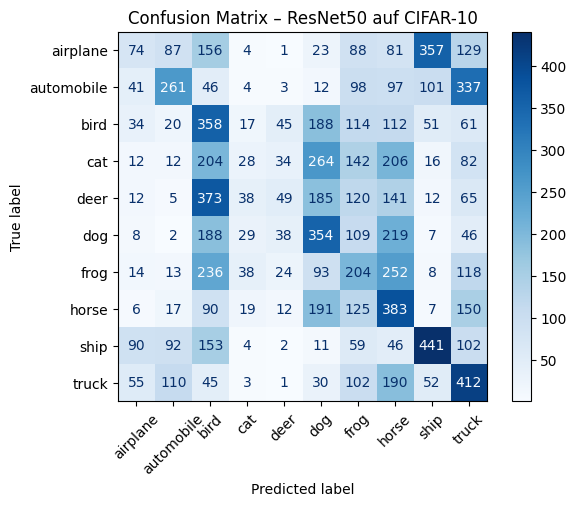

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix – ResNet50 auf CIFAR-10")
plt.show()


---
---
---

## **BLOCK 2: ResNet50 (Feintuning ON) - Experiment**

In [96]:
#Eingabeschicht für CIFAR-10 (32x32 RGB)
inputs = Input(shape=(32, 32, 3))

#Hochskalieren auf 224x224 (ResNet50 erwartet das)
x = layers.Resizing(224, 224)(inputs)

#ResNet50 Basis laden – OHNE Kopf
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Feintuning aktivieren – komplette Basis trainierbar (optional: nur die letzten N Layer)
base_model.trainable = True

#Merkmalsextraktion
x = base_model(x, training=True)  # Training=True nötig für BatchNorm etc.

#Klassifikationskopf
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

#Modell definieren
model = models.Model(inputs, outputs)

#Kompilieren – sehr kleine Lernrate!
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Zusammenfassung anzeigen
model.summary()

#Training starten
history = model.fit(
    train_images, train_labels_cat,
    epochs=10,
    batch_size=32,
    validation_data=(test_images, test_labels_cat)
)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_7 (Resizing)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 23,805,770 (90.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 207s 479ms/step - accuracy: 0.2990 - loss: 2.0365 - val_accuracy: 0.1000 - val_loss: 4.0658
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 161s 414ms/step - accuracy: 0.7728 - loss: 0.7823 - val_accuracy: 0.1008 - val_loss: 2.8548
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 360ms/step - accuracy: 0.9089 - loss: 0.3341 - val_accuracy: 0.6589 - val_loss: 1.0417
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 128s 411ms/step - accuracy: 0.9539 - loss: 0.1806 - val_accuracy: 0.8612 - val_loss: 0.4260
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 358ms/step - accuracy: 0.9813 - loss: 0.0912 - val_accuracy: 0.8815 - val_loss: 0.3740
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 159s 412ms/step - accuracy: 0.9920 - loss: 0.0522 - val_accuracy: 0.8848 - val_loss: 0.3707
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 359ms/step - accuracy: 0.9936 - loss: 0.0356 - val_accuracy: 0.8856 - val_loss: 0.3845
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 129s 413ms/step - accuracy: 0.9967 -

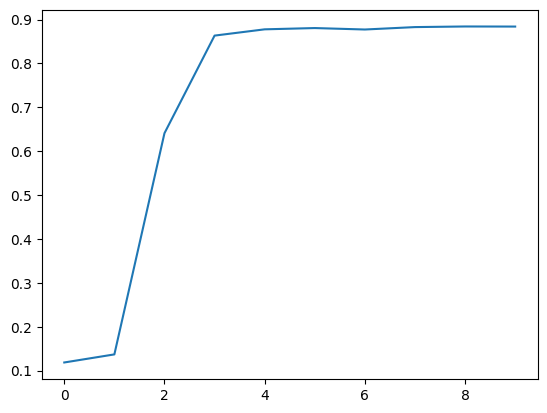

In [ ]:
plt.plot(history.history['val_accuracy'], label='ResNet50 (Unfrozen)')

**Confusion Matrix für ResNet50 (UNFROZEN)**

In [ ]:
#Echte Klassenlabels zurückholen
y_true = np.argmax(test_labels_cat, axis=1)

#Vorhersagen vom Modell (unfrozen) erzeugen
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step


**Confusion Matrix plotten**

<Figure size 1000x800 with 0 Axes>

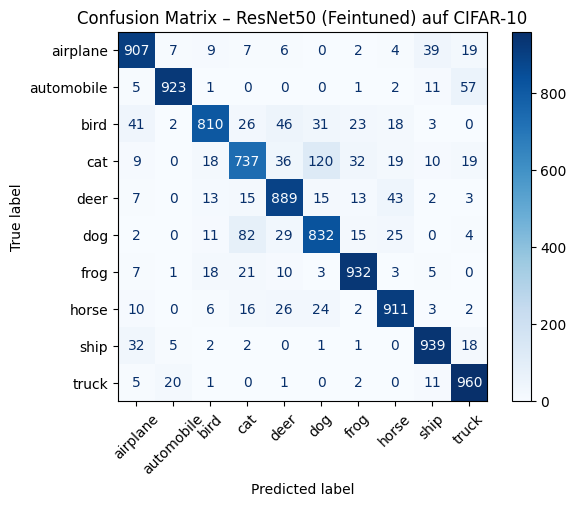

In [ ]:
#Klassenlabels (CIFAR-10)
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

#Confusion Matrix berechnen
cm = confusion_matrix(y_true, y_pred)

#Anzeige
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix – ResNet50 (Feintuned) auf CIFAR-10")
plt.show()


# Fazit & Reflexion

## Modellvergleich: ResNet50 (Frozen vs. Feintuned)

### Ziel
Vergleich der Klassifikationsleistung zweier Varianten des ResNet50-Modells auf dem CIFAR-10-Datensatz:
- **Frozen**: Nur der Klassifikationskopf wurde trainiert
- **Feintuned**: Das gesamte Modell inkl. CNN-Feature-Extraktor wurde weitertrainiert

---

### Ergebnisse (Validation Accuracy)

| Epoche | ResNet50 (Frozen) | ResNet50 (Feintuned) |
|--------|--------------------|------------------------|
| 1      | 0.30               | 0.10                  |
| 2      | 0.48               | 0.65                  |
| 3      | 0.23               | 0.86                  |
| 5      | 0.24               | 0.88                  |
| 10     | 0.25               | **0.89**              |

---

### Beobachtungen

- **Frozen-Variante** lernt langsam und bleibt bei ca. 25% Val-Accuracy stehen
- **Feintuned-Variante** lernt deutlich schneller und erreicht fast **90% Genauigkeit**
- Die **Confusion Matrix** zeigt bei der frozen-Version viele Verwechslungen (z.B. cat vs. dog)
- Das feingetunte Modell trennt Klassen **klar und präzise**

---

### Fazit

Das Feintuning des vollständigen ResNet50-Modells verbessert die Klassifikationsleistung auf CIFAR-10 **deutlich**.  
Während die frozen-Version visuelle Grundstrukturen nutzt, ermöglicht das Feintuning eine **optimierte Merkmalsextraktion**, die besonders bei ähnlichen Klassen (z.B. cat vs. dog) entscheidend ist.

Für realistische Szenarien ist ein **angepasstes Fine-Tuning essenziell**, wenn man mit pretrained CNNs arbeitet.
